<a href="https://colab.research.google.com/github/amaljithmohan/GAN-Project/blob/main/BasicGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Networks (GAN)

In [1]:
from matplotlib import pyplot

In [2]:
# loading the mnist dataset
from tensorflow.keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


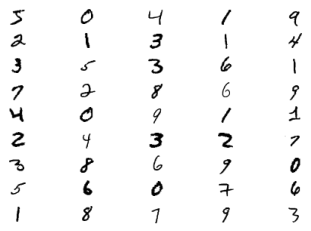

In [3]:
for i in range(45):
	# define subplot
	pyplot.subplot(9, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 
#The generator model defined in this function takes in a random noise vector of length 100 and outputs a generated image with a shape of (28, 28, 1). 
#The model architecture consists of several layers:

#The first layer is a dense layer that takes in the noise vector as input and outputs a tensor of shape (7, 7, 256).
#A batch normalization layer is added to normalize the activations of the previous layer.
#A LeakyReLU activation function is added to introduce non-linearity into the model.
#The output of the previous layer is then reshaped to (7, 7, 256).
#A convolutional transpose layer with 128 filters, a filter size of (5, 5), and a stride of (1, 1) is added to upsample the previous layer to (7, 7, 128).
#Another batch normalization layer and LeakyReLU activation function are added to normalize the activations and introduce non-linearity into the model.
#Another convolutional transpose layer with 64 filters, a filter size of (5, 5), and a stride of (2, 2) is added to upsample the previous layer to (14, 14, 64).
#Another batch normalization layer and LeakyReLU activation function are added to normalize the activations and introduce non-linearity into the model.
#The final layer is a convolutional transpose layer with a single filter, a filter size of (5, 5), a stride of (2, 2), and a tanh activation function. 
#This layer outputs the generated image with a shape of (28, 28, 1).

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

   # upsample to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # upsample to 28x28
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

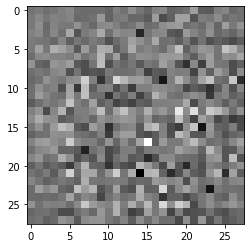

In [10]:
# sample image generated by the the generator
generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Input to discriminator = 28*28*1   grayscale image
Output  binary prediction (image is real (class=1) or fake (class=0))
no pooling layers  
 single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction

The discriminator model defined in this function takes in an image with a shape of (28, 28, 1) and outputs a binary classification of either real or fake (1 or 0). 
The model architecture consists of several layers:

The first layer is a convolutional layer with 64 filters, a filter size of (5, 5), and a stride of (2, 2). This layer downsamples the input image by a factor of 2.
A LeakyReLU activation function is added to introduce non-linearity into the model.
A dropout layer is added to regularize the model and prevent overfitting.
Another convolutional layer with 128 filters, a filter size of (5, 5), and a stride of (2, 2) is added. This layer further downsamples the input image by a factor of 2.
Another LeakyReLU activation function and dropout layer are added.
The output of the previous layer is flattened into a one-dimensional vector.
A dense layer with a single neuron and a sigmoid activation function is added to output the binary classification.

In [12]:



def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50043803]], shape=(1, 1), dtype=float32)


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

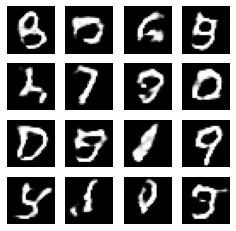

In [23]:
train(train_dataset, EPOCHS)

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))